# minGPT

From https://github.com/karpathy/minGPT

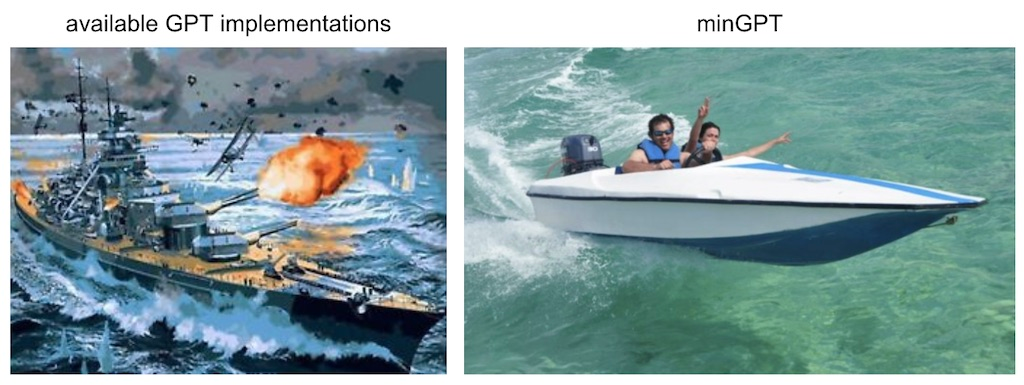

A PyTorch re-implementation of [GPT](https://github.com/openai/gpt-3) training.

The inputs are simple text files, which we chop up to individual characters and then train GPT on.

- Transformer: [arXiv:1706.03762 [cs.CL]](https://arxiv.org/abs/1706.03762)
- GPT-1: https://openai.com/blog/language-unsupervised/
- GPT-2: https://openai.com/blog/better-language-models/
- GPT-3: [arXiv:2005.14165 [cs.CL]](https://arxiv.org/abs/2005.14165)

## Configuration

Imports

In [1]:
import math
import random
from collections import defaultdict
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

Configuration

In [2]:
DATA_FILE = "dievu-miskas.txt"
SAVE_PATH = 'weights-mingpt.pkl'

BLOCK_SIZE = 128 # spatial extent of the model for its context
NUM_WORKERS = 4

BATCH_SIZE = 128
LEARNING_RATE = 6e-4
EPOCHS = 2

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Make deterministic

In [5]:
set_seed(42)

## Dataset

In [6]:
class CharDataset(torch.utils.data.Dataset):
    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print(f'data has {data_size} characters, {vocab_size} unique.')
        
        self.stoi = {ch:i for i, ch in enumerate(chars)}
        self.itos = {i:ch for i, ch in enumerate(chars)}
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # arrange data and targets so that the first i elements of x will be asked to predict
        # the i-th element of y. The language model will make block_size individual predictions
        # at the same time
        chunk = self.data[idx:idx + self.block_size + 1]
        dix = [self.stoi[s] for s in chunk]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [7]:
with open(DATA_FILE) as f:
    text = f.read()

In [8]:
train_dataset = CharDataset(text, BLOCK_SIZE)

data has 622564 characters, 98 unique.


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                           batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

## Model

In [10]:
class GPTConfig:
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k, v in kwargs.items():
            setattr(self, k, v)

Attention:
$$
O=V\mathrm{softmax}\left(\frac{1}{\sqrt{c}}K^{\intercal}Q\right)\,,
$$
where $V,K,Q\in\mathbb{R}^{c\times n}$, $c$ is the number of channels, $n$ is the number of pixels. Here $K^{\intercal}Q\in\mathbb{R}^{n\times n}$.

It is possible to use `torch.nn.MultiheadAttention`:

In [11]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        n_embd = config.n_embd
        self.n_head = config.n_head
        assert n_embd % self.n_head == 0

        self.to_keys = nn.Linear(n_embd, n_embd)
        self.to_queries = nn.Linear(n_embd, n_embd)
        self.to_values = nn.Linear(n_embd, n_embd)
        self.unifyheads = nn.Linear(n_embd, n_embd)

        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)

        # causal mask to ensure that attention is only applied to the left in the input sequence:
        # upper triangular part of the matrix
        bs = config.block_size
        self.register_buffer("mask", torch.triu(torch.ones((1,1,bs,bs), dtype=torch.bool), diagonal=1))

    def forward(self, x, layer_past=None):
        b, t, c = x.size()
        h, c_q = self.n_head, c // self.n_head

        keys = self.to_keys(x).view(b, t, h, c_q).transpose(1, 2) # move head forward to the batch dim
        queries = self.to_queries(x).view(b, t, h, c_q).transpose(1, 2)
        values = self.to_values(x).view(b, t, h, c_q).transpose(1, 2)

        att = queries @ keys.transpose(-2, -1)
        att = att.masked_fill(self.mask[:, :, :t, :t], float('-inf'))
        att = F.softmax(att * c_q**-0.5, dim=-1)
        att = self.attn_drop(att)
        
        out = att @ values
        out = out.transpose(1, 2).contiguous().view(b, t, c) # move head back
        out = self.unifyheads(out)
        out = self.resid_drop(out)
        return out

In [12]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        n_embd = config.n_embd
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(), # Gaussian Error Linear Units
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [13]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.Tensor(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer encoder
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_d = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.reset_parameters()

    
    def get_block_size(self):
        return self.block_size
    

    def forward(self, x):
        b, t = x.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        token_embeddings = self.tok_emb(x)
        position_embeddings = self.pos_emb[:, :t, :]
        x = token_embeddings + position_embeddings
        x = self.drop(x)
        x = self.blocks(x)
        x = self.ln_d(x)
        logits = self.head(x)

        return logits
    
    
    def reset_parameters(self):
        nn.init.zeros_(self.pos_emb)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
    
    
    def separate_parameters(self):
        # biases, and layernorm/embedding weights will not be decayed for regularization
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, )
        modules_no_weight_decay = (nn.LayerNorm, nn.Embedding)
    
        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name
                
                if param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name) # all biases will not be decayed
                elif param_name.endswith('weight'):
                    if isinstance(m, modules_weight_decay):
                        parameters_decay.add(full_param_name) # weights will be weight decayed
                    elif isinstance(m, modules_no_weight_decay):
                        parameters_no_decay.add(full_param_name) # weights will NOT be weight decayed

        # special case the position embedding parameter in the root GPT module as not decayed
        parameters_no_decay.add('pos_emb')
    
        return parameters_decay, parameters_no_decay

In [14]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)

In [15]:
model = GPT(mconf).to(DEVICE)

## Loss

In [16]:
class GPT_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, logits, target):
        return self.criterion(logits.view(-1, logits.size(-1)), target.view(-1))

In [17]:
loss = GPT_Loss()

## Optimizer

In [18]:
def get_optimizer(model, learning_rate, weight_decay, betas):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate, betas=betas)
    return optimizer

In [19]:
optimizer = get_optimizer(model, learning_rate=3e-4, weight_decay=0.1, betas=(0.9, 0.95))

## Learning Rate Sheduler

In [20]:
class GPT_Sheduler:
    def __init__(self, optimizer, max_lr, warmup_tokens, final_tokens, div_factor=25.):
        self.optimizer = optimizer
        self.max_lr = max_lr
        self.warmup_tokens = warmup_tokens
        self.decay_tokens = final_tokens - warmup_tokens
        self.div_factor = div_factor
        self.reset()
    
    def step(self, num_tok):
        self.tokens += num_tok
        if self.tokens < self.warmup_tokens: # linear warmup
            lr_mult = float(self.tokens) / max(1, self.warmup_tokens)
        else: # cosine learning rate decay
            progress = float(self.tokens - self.warmup_tokens) / max(1, self.decay_tokens)
            cos_out = 0.5 * (math.cos(math.pi * progress) + 1.)
            lr_mult = max(0.1, cos_out)
        
        self.set_lr(self.max_lr * lr_mult)
    
    def get_lr(self):
        return self.lr
    
    def set_lr(self, lr):
        self.lr = lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
    
    def reset(self):
        self.tokens = 0
        self.set_lr(self.max_lr / self.div_factor)

In [21]:
sheduler = GPT_Sheduler(optimizer, max_lr=LEARNING_RATE, warmup_tokens=512*20,
                       final_tokens=EPOCHS*len(train_dataset)*BLOCK_SIZE)

## Training

In [22]:
def show_or_save(fig, filename=None):
    if filename:
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

In [23]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def plot(self, key, x_is_batch=True, ylog=False, filename=None):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        xs = np.arange(1, len(self.values[key])+1)
        ax.plot(xs, self.values[key], '-', label=key)
        if ylog: ax.set_yscale('log')
        ax.set_xlabel('batch' if x_is_batch else 'epoch')
        ax.set_ylabel(key)
        show_or_save(fig, filename)

In [24]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, device,
                batch_scheduler=None, grad_norm_clip = 1.0):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.device = device
        self.grad_norm_clip = grad_norm_clip
        self.batch_scheduler = batch_scheduler
        self.history = History()
    
    def iterate(self, loader, epoch):
        pbar = tqdm(enumerate(loader), total=len(loader))
        for it, (X, Y) in pbar:
            X, Y = X.to(self.device), Y.to(self.device)
            Y_pred = self.model(X)
            batch_loss = self.loss(Y_pred, Y)
            self.history.append('train loss', batch_loss.item())
            
            self.optimizer.zero_grad()
            batch_loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_norm_clip)
            self.optimizer.step()
            
            for param_group in self.optimizer.param_groups:
                lr = param_group['lr']
            self.history.append('lr', lr)
            
            if self.batch_scheduler is not None:
                num_tok = (Y >= 0).sum()
                self.batch_scheduler.step(num_tok)
            
            pbar.set_description("epoch {} iter {}: train loss {:.4f} lr {:.4e}".format(
                epoch+1, it, batch_loss.item(), lr))
    
    def fit(self, epochs):
        for e in range(epochs):
            self.model.train()
            self.iterate(self.train_loader, e)

In [25]:
learner = Learner(model, loss, optimizer, train_loader, DEVICE, batch_scheduler=sheduler)

In [26]:
learner.fit(EPOCHS)

epoch 1 iter 4862: train loss 0.2065 lr 3.0011e-04: 100%|██████████| 4863/4863 [1:01:28<00:00,  1.32it/s]
epoch 2 iter 4862: train loss 0.1270 lr 6.0000e-05: 100%|██████████| 4863/4863 [1:01:36<00:00,  1.32it/s]


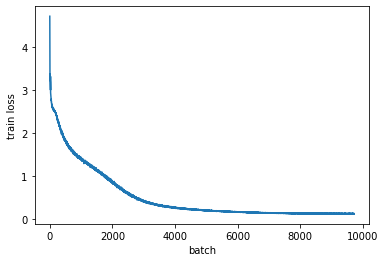

In [27]:
learner.history.plot('train loss')

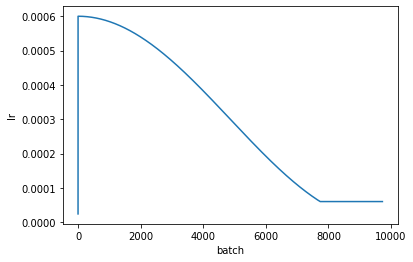

In [28]:
learner.history.plot('lr')

In [29]:
torch.save(model.state_dict(), SAVE_PATH)

## Sampling

In [16]:
def top_k_logits(logits, k):
    v, _ = torch.topk(logits, k)
    logits[logits < v[:, -1:]] = float('-inf')
    return logits

Take a conditioning sequence of indices in `x` (of shape `(b,t)`) and predict the next token in
the sequence, feeding the predictions back into the model each time.

In [17]:
@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits = model(x_cond)
        logits = logits[:, -1, :] / temperature # take the logits at the final step
        if top_k is not None: # crop to only the top k options
            logits = top_k_logits(logits, top_k)
        probs = F.softmax(logits, dim=-1) # convert to probabilities
        
        if sample: # sample from the distribution or take the most likely
            ix = torch.multinomial(probs, num_samples=1)
        else:
            ix = torch.argmax(probs, dim=-1, keepdim=True)
        
        x = torch.cat((x, ix), dim=1) # append to the sequence
    return x

In [18]:
model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [36]:
context = "Baltijos pažangių technologijų institutas"

In [37]:
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)
x = x.unsqueeze(0).to(DEVICE)

In [44]:
y = sample(model, x, 2000, temperature=1.0, sample=True, top_k=10)[0]

In [ ]:
completion = ''.join([train_dataset.itos[int(i)] for i in y])
print(completion)

**Context**: Lietuvos žaliųjų ir valstiečių partija

**Output**:

Lietuvos žaliųjų ir valstiečių partija nebuvo. Būti tai buvo, bet jie jau buvo suspėję dingti. Taip sau, be pėdsako. Liko tiktai keturi, geri meisteriai specialistai. Laikėsi jie nuošaliai ir kukliai, pasinėrę darbo kolonose. Valdžia, atrodė, juos visiškai buvo pamiršusi.

**Context**: Baltijos pažangių technologijų institutas

**Output**:

Baltijos pažangių technologijų institutas buvo itin įvairus. Buvo čia įvairių tautų politiniai veikėjai, bet buvo ir žmonės, kurie niekuomet nieko bendra su politika neturėjo.

Iš vokiečių čia buvo vienas kitas likęs senųjų vokiečių kairiųjų partijų atstovas, koks centro partijos veikėjas, — ir dar šis tas. Buvo vienas net iš pirmųjų dešimties nacionalsocialistų partijos narių, artimas Hitlerio bendradarbis, buvęs nacių oficiozo „Angriff” laikraščio redaktorius.